In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


import requests
from bs4 import BeautifulSoup

import os


#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans


print('Libraries imported.')







Libraries imported.


## Introduction/Business Problem

New York is a big city and is most populous and most densely populated city in the United States. The city has a diverse culture and has been the premier gateway for legal immigrants. This makes it the most culturally and linguistically diverse city an in the world. This also means that New York offers a diverse cuisine and varied restaurants. 

This analysis will try to help an hotelier gauge on which will be the best location in New York to open an Indian restaurant


## Data
https://cocl.us/new_york_dataset - Data on New York City with Boroughs, Neighborhood  to get an insight on the neighborhood

Fousquare API - Data to get into neighborhoods and venues to get details on Indian restaurants to find which place an Indian restaurant is most popular and also to get details on the competition and kinds of menus offered.

https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm – New York Boroughs boundary


## 1. Download and Explore Dataset


In [51]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [52]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

#### Define function to get latitude and longitude

In [71]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### Define function to connect to FourSquare API and get 100 venues within 700 metres of a given latitude,longitude

In [2]:
def get_venues(lat,lng):
    
    #set variables
    radius=700
    LIMIT=100
    CLIENT_ID = 'S4BQLPFZCCZPIZGWDWSTFAUXZVFQ2FKONIFXQ2GRYTYPKUXF' # your Foursquare ID
    CLIENT_SECRET = 'UYQZSNROEDEGPKEASEXE5J5JYEYPKEYZ2NAHFTTERYB5MS5M' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
    venue_data = requests.get(url).json()["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df



#### Define function to connect with FourSquare API and get Venue details

In [2]:
def get_venue_details(venue_id):
        
    CLIENT_ID = "S4BQLPFZCCZPIZGWDWSTFAUXZVFQ2FKONIFXQ2GRYTYPKUXF" # your Foursquare ID
    CLIENT_SECRET = "UYQZSNROEDEGPKEASEXE5J5JYEYPKEYZ2NAHFTTERYB5MS5M" # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    venue_data = requests.get(url).json()['response']['venue']
    venue_details=[]

    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
        

#### get data 

In [53]:
# define the dataframe columns
import pandas as pd
neighborhoods = pd.DataFrame()

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

neighborhoods_data = newyork_data['features']
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [54]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude


In [55]:
neighborhoods_data = newyork_data['features']

In [56]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [28]:
neighborhoods.shape

(306, 4)

In [57]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### 306 Neighborhoods

In [31]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


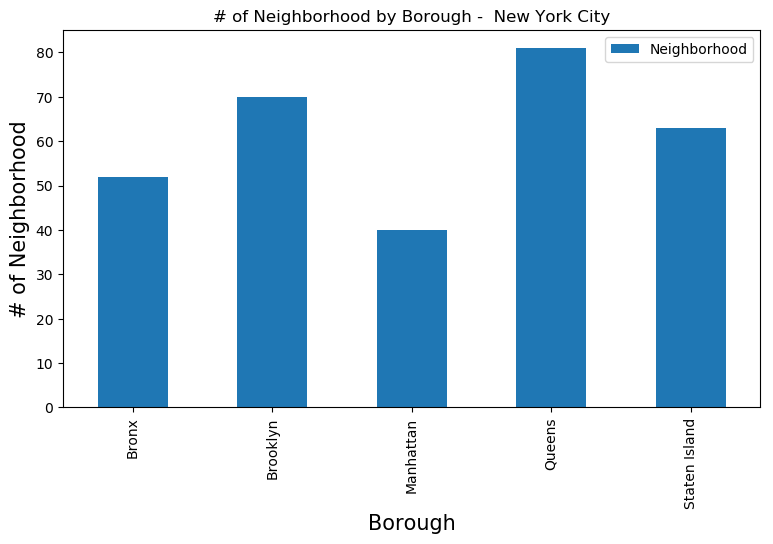

In [33]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('# of Neighborhood by Borough -  New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('# of Neighborhood', fontsize=15)
#giving a bar plot
neighborhoods.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Queens has maximum number of neighborhoods

### Indian restaurants for each Neighborhood

In [34]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in neighborhoods.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']
    print('(',count,')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    for restaurant_detail in indian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 ) Indian Restaurants in Wakefield, Bronx:0
( 2 ) Indian Restaurants in Co-op City, Bronx:0
( 3 ) Indian Restaurants in Eastchester, Bronx:0
( 4 ) Indian Restaurants in Fieldston, Bronx:0
( 5 ) Indian Restaurants in Riverdale, Bronx:1
( 6 ) Indian Restaurants in Kingsbridge, Bronx:0
( 7 ) Indian Restaurants in Marble Hill, Manhattan:0
( 8 ) Indian Restaurants in Woodlawn, Bronx:1
( 9 ) Indian Restaurants in Norwood, Bronx:0
( 10 ) Indian Restaurants in Williamsbridge, Bronx:0
( 11 ) Indian Restaurants in Baychester, Bronx:0
( 12 ) Indian Restaurants in Pelham Parkway, Bronx:0
( 13 ) Indian Restaurants in City Island, Bronx:0
( 14 ) Indian Restaurants in Bedford Park, Bronx:0
( 15 ) Indian Restaurants in University Heights, Bronx:0
( 16 ) Indian Restaurants in Morris Heights, Bronx:0
( 17 ) Indian Restaurants in Fordham, Bronx:0
( 18 ) Indian Restaurants in East Tremont, Bronx:0
( 19 ) Indian Restaurants in West Farms, Bronx:0
( 20 ) Indian Restaurants in High  Bridge, Bronx:0
( 21 )

In [35]:
indian_rest_ny.head()
    

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine
1,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
3,Bronx,Parkchester,5c371f9adee770002b4c3c39,Tandoori Place
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


#### Indian restaurants in New York City

In [36]:

indian_rest_ny.shape

(112, 4)

#### 112 Indian restaurants in  New York
Note: Data has been restricted due to limitation in API calls to FourSquare

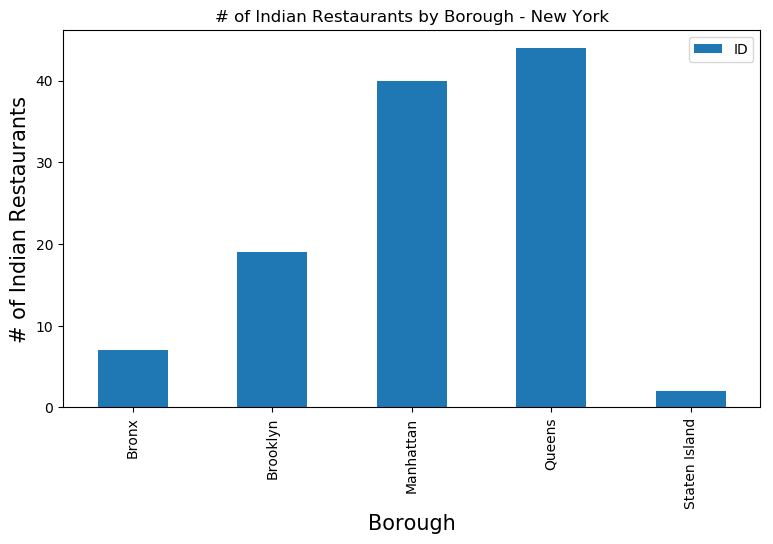

In [39]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('# of Indian Restaurants by Borough - New York')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('# of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

##### Queens has largest number of Indian restaurants follow by Manhattan

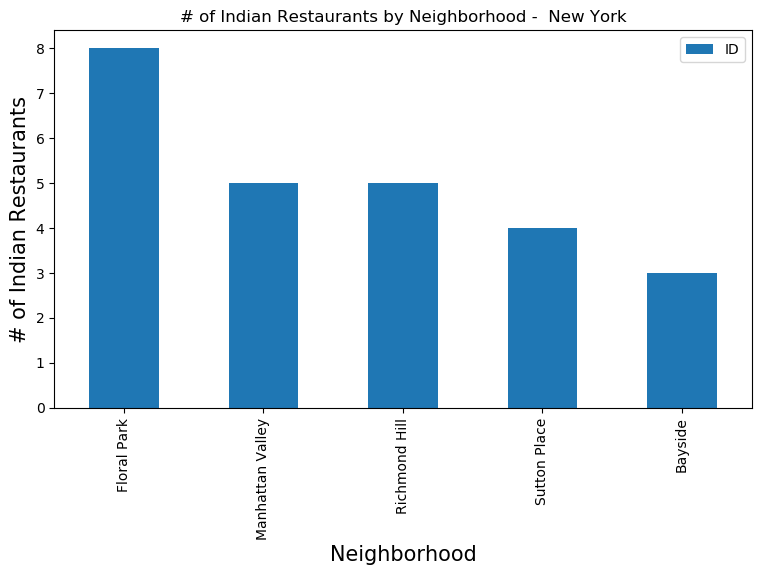

In [40]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('# of Indian Restaurants by Neighborhood -  New York')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('# of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### Floral Park Neighborhood as highest number of Indian Restaurants

In [41]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
74,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
75,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
76,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
77,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
78,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
79,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
80,Queens,Floral Park,4ec1b54f4690d2338a359d66,Tabaq Kebab Grill
81,Queens,Floral Park,4c3e17f2ca012d7f82022fbe,Mushin's Halal Food [Gyro Cart]


#### Save data into CSV

In [43]:
indian_rest_ny.to_csv('indian_rest_ny.csv', index=False)

In [3]:
indian_rest_ny_csv=pd.read_csv('indian_rest_ny.csv')

In [4]:
indian_rest_ny_csv.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine
1,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
3,Bronx,Parkchester,5c371f9adee770002b4c3c39,Tandoori Place
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


#### Floral Park neighborhood has 8 restaurants

#### Analyze data from FourSquare for further analysis

In [5]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny_csv.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        #  assign 0 value for restaurants not available in FourSquare 
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny_csv),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.2     9
( 1 / 112 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      4     7.8    10
( 2 / 112 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.2     2
( 3 / 112 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 5c371f9adee770002b4c3c39
( 4 / 112 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     7.6     3
( 5 / 112 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.2     2
( 6 / 112 ) processed
                         ID          Name  Likes  

KeyError: 'venue'

In [6]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.2,9
1,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,7.8,10
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.2,2
3,Bronx,Parkchester,0,0,0,0.0,0
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.6,3


In [7]:
indian_rest_stats_ny.shape

(50, 7)

## 50 Indian restaurants have stats

In [8]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [77]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [78]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [79]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine,13.0,6.2,9.0
1,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4.0,7.8,10.0
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3.0,6.2,2.0
3,Bronx,Parkchester,0,0,0.0,0.0,0.0
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8.0,7.6,3.0


#### Data Cleanup

In [12]:

indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


In [13]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [14]:

indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')


In [15]:

indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


#### Most Liked Restaurant

In [16]:

indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                823
Rating                               8.8
Tips                                 257
Name: 35, dtype: object

#### Most rated Restaurant

In [17]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                571
Rating                                 9
Tips                                 142
Name: 39, dtype: object

#### Most Tipped Restaurant

In [18]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                823
Rating                               8.8
Tips                                 257
Name: 35, dtype: object

#### Neighborhood with maximum average rating

In [46]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [47]:

ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
28,Tribeca,9.000000
27,South Side,8.800000
19,Midtown,8.800000
21,North Side,8.800000
13,Greenwich Village,8.750000
4,Chelsea,8.700000
12,Gramercy,8.666667
10,Fort Greene,8.600000
33,Yorkville,8.400000
6,Clinton Hill,8.300000


#### Top Neighborhood with Top Average Rating

#### averaging rating by Borough

In [ ]:
ny_borough_stats=indian_rest_stats_ny_csv.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [99]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.036000
1,Brooklyn,7.031579
0,Bronx,5.666667


### Average Restaurant Rating in each Borough

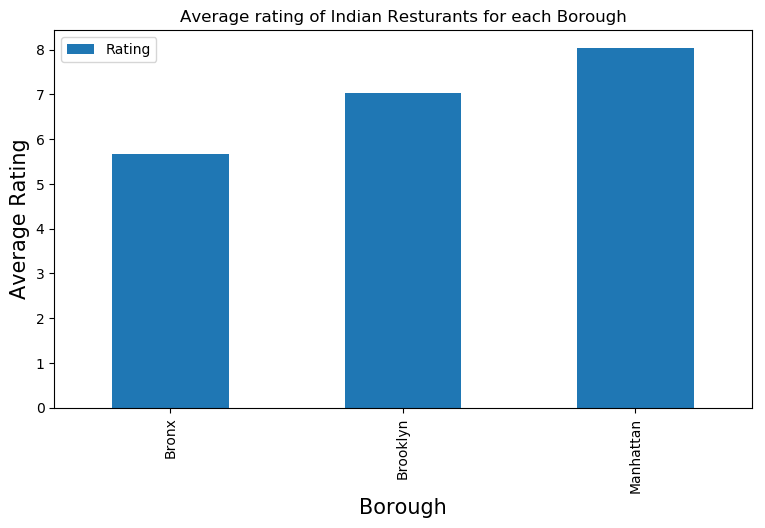

In [43]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### Manhattan shows as leading place for Indian restaurants

### Neighborhoods with restaurants having average ratings >=8

In [85]:

# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

#### Merge data to get latitude and longitude

#### Visualize Neighborhoods

In [87]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [89]:
ny_neighborhood_stats.head()

,Borough_x,Neighborhood,ID_x,Name_x,Likes,Rating,Tips,Borough_y,ID_y,Name_y,Borough,Latitude,Longitude
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.2,9,Bronx,4c04544df423a593ac83d116,Cumin Indian Cuisine,Bronx,40.890834,-73.912585
1,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,7.8,10,Bronx,4c0448d9310fc9b6bf1dc761,Curry Spot,Bronx,40.898273,-73.867315
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.2,2,Bronx,4c194631838020a13e78e561,Melanies Roti Bar And Grill,Bronx,40.837938,-73.856003
3,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.2,2,Bronx,5c371f9adee770002b4c3c39,Tandoori Place,Bronx,40.837938,-73.856003
4,Bronx,Parkchester,0,0,0,0.0,0,Bronx,4c194631838020a13e78e561,Melanies Roti Bar And Grill,Bronx,40.837938,-73.856003


In [90]:

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Rating'].map(str)+')'

In [91]:

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

#### Visualize boroughs

In [96]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

#### Now that we have visualized the Neighborhoods. 
Lets Visualize Boroughs based on average Rating

In [61]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'newyork_data.json'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

#### Conclusion
Manhattan seems to be the best place for Indian restaurants 
   followed by Brooklyn
Though Queens has largest number of Indian restaurants , 
    Indian restaurants are more liked and favored in Manhattan followed by     
    Brooklyn
